In [512]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [513]:
# Read the raw data
# Everything before the train_test_split is called "raw data"
raw_data = pd.read_csv('./data/ULEV Registrations As of 2022.csv')

# Clean up and reorganize data

# Store the geographical correspondence seperately
geo_data = raw_data.filter(regex=r'ONS Code|ONS Geography|ONS Sort')
# Strip whitespaces in geographic regions
geo_data['ONS Geography [note 6]'].str.lstrip()
# Renmae columns
geo_data = geo_data.rename(columns={"ONS Geography [note 6]": "geo", "ONS Code": "code", "ONS Sort": "sort"})

# The real data used to train the models
# We only care about the ONS Geography or the quarterly registration
raw_data = raw_data.filter(regex=r'ONS Code|Q')

# Melt the data to put quarter as a number instead of a column
raw_data = raw_data.melt(id_vars='ONS Code', var_name='Quarter', value_name='val')
# Extract the digits out of the quarter
raw_data['Quarter'] = raw_data['Quarter'].str.extract('(\d+)', expand=False).astype(int)
# Rename the columns
raw_data = raw_data.rename(columns={"Quarter": "quarter", "ONS Code": "code"})

# Sort the data by quarter
raw_data = raw_data.sort_values(['quarter'])

In [514]:
raw_data

,code,quarter,val
17260,N09000010,1,0
16972,E07000192,1,39
16973,E07000193,1,0
16974,E07000194,1,13
16975,E07000195,1,0
...,...,...,...
285,E07000112,41,72
286,E07000109,41,75
287,E07000110,41,187
263,E07000061,41,66


In [515]:
# Our polynomial model of the trend line

def poly(x, A, B, C, D):
    return A*x**3 + B*x**2 + C*x + D

def fit_poly(prev_data):
    from scipy.optimize import curve_fit

    # Rolling window includes the current point, we shall exclude it beacause 'diff' is the difference between the baseline fit and true value at the CURRENT POINT.
    prev_data = prev_data.iloc[:prev_data.shape[0] - 1]
    
    parameters, covariant_matrix = curve_fit(poly, np.arange(0, prev_data.shape[0] ), prev_data)

    A = parameters[0]
    B = parameters[1]
    C = parameters[2]
    D = parameters[3]
    
    # print("%d, %d, %d, %d" % (A, B, C, D))
    
    # Rolling window includes the current point, we shall exclude it beacause 'diff' is the difference between the baseline fit and true value at the CURRENT POINT.
    return poly(prev_data.shape[0], A, B, C, D)

In [516]:
# Window size is the number of the previous dataset size that we are trying fit our baseline upon
# window_size = 4 means we are looking at previous 3 data points to create our baseline prediction for the current quarter
def append_baseline_prediction(x, window_size):
    # Rolling window includes the current point, we shall exclude it beacause 'diff' is the difference between the baseline fit and true value at the CURRENT POINT.
    x["base"] = x.groupby("code")["val"].rolling(window_size).apply(fit_poly).reset_index(level=0, drop=True)
    x["diff"] = x["val"] - x["base"]
    
# use previous window_size = 5 instead of 4 seems to produce way better fit
# 6 seems to be better
append_baseline_prediction(raw_data, 5)

/nix/store/7vl4vagsr6b5lymv2nbaf8sz03vzn5aa-python3-3.10.8-env/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


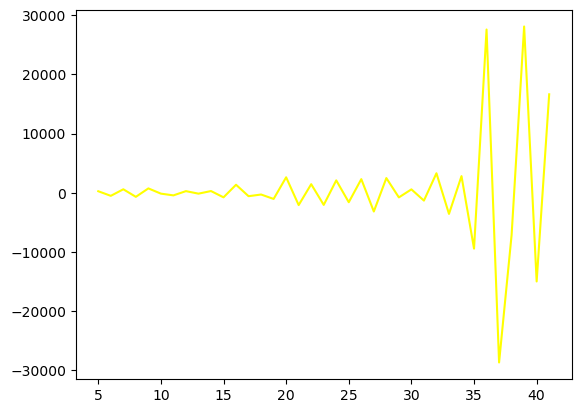

In [517]:
# Now let's generate a baseline fit and see how it performs
# code = "E06000003"
# code = "E07000080"
code = "K02000001"

# Actual data
# plt.plot(np.arange(1, 42), raw_data[raw_data["code"] == code ]["val"], color = "blue")
# Prediction by baseline fit
# plt.plot(np.arange(1, 42), raw_data[raw_data["code"] == code]["base"], color = "red")
# difference in them
plt.plot(np.arange(1, 42), raw_data[raw_data["code"] == code ]["diff"], color = "yellow")

In [518]:
# Now let's append other features used by random forest
# A function that expand each row (datapoint) with features
def append_feats(x, mean_period):
    # Caveats: the last quarter doesn't have next_val and the 8 quarter doesn't have std
    # We don't use these incomplete data
    x["prev_diff"] = x.groupby('code')["diff"].shift(1)
    # difference between the consecutive fluctuation
    x["diff_diff"] = x.groupby('code')["diff"].diff()
    x["next_diff"] = x.groupby('code')["diff"].shift(-1)
    x["next_val"] = x.groupby('code')["val"].shift(-1)
    x["diff_std"] = x.groupby("code")["diff"].rolling(mean_period).std().reset_index(level=0, drop=True)
    x["diff_mean"] = x.groupby("code")["diff"].rolling(mean_period).mean().reset_index(level=0, drop=True)

append_feats(raw_data, 3)

In [519]:
raw_data[raw_data["code"] == code]

,code,quarter,val,base,diff,prev_diff,diff_diff,next_diff,next_val,diff_std,diff_mean
16840,K02000001,1,5541,NaN,NaN,NaN,NaN,NaN,5715.0,NaN,NaN
16419,K02000001,2,5715,NaN,NaN,NaN,NaN,NaN,5877.0,NaN,NaN
15998,K02000001,3,5877,NaN,NaN,NaN,NaN,NaN,5993.0,NaN,NaN
15577,K02000001,4,5993,NaN,NaN,NaN,NaN,257.0,6286.0,NaN,NaN
15156,K02000001,5,6286,6029.0,257.0,NaN,NaN,-519.0,6460.0,NaN,NaN
14735,K02000001,6,6460,6979.0,-519.0,257.0,-776.0,586.0,6805.0,NaN,NaN
14314,K02000001,7,6805,6219.0,586.0,-519.0,1105.0,-688.0,6923.0,567.368487,1.080000e+02
13893,K02000001,8,6923,7611.0,-688.0,586.0,-1274.0,736.0,7152.0,691.937136,-2.070000e+02
13472,K02000001,9,7152,6416.0,736.0,-688.0,1424.0,-148.0,7682.0,782.448294,2.113333e+02
13051,K02000001,10,7682,7830.0,-148.0,736.0,-884.0,-442.0,8261.0,718.891740,-3.333333e+01


In [521]:
# Now we try to use random forest to predict the difference between the y_true and our baseline fit

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

ohe = OneHotEncoder(sparse_output = False)

ct = ColumnTransformer([('geo_encoder', ohe, ['code'])], remainder='passthrough')
ct.set_output(transform = 'pandas')

encoded_data = ct.fit_transform(raw_data)

In [522]:
encoded_data

,geo_encoder__code_E06000001,geo_encoder__code_E06000002,geo_encoder__code_E06000003,geo_encoder__code_E06000004,geo_encoder__code_E06000005,geo_encoder__code_E06000006,geo_encoder__code_E06000007,geo_encoder__code_E06000008,geo_encoder__code_E06000009,geo_encoder__code_E06000010,...,remainder__quarter,remainder__val,remainder__base,remainder__diff,remainder__prev_diff,remainder__diff_diff,remainder__next_diff,remainder__next_val,remainder__diff_std,remainder__diff_mean
17260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
16972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,39,NaN,NaN,NaN,NaN,NaN,39.0,NaN,NaN
16973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
16974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,13,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN
16975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,41,72,54.0,18.0,-3.0,21.0,NaN,NaN,11.846237,4.333333
286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,41,75,21.0,54.0,-62.0,116.0,NaN,NaN,61.419324,7.666667
287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,41,187,158.0,29.0,-44.0,73.0,NaN,NaN,48.569538,11.000000
263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,41,66,59.0,7.0,-25.0,32.0,NaN,NaN,28.095077,4.333333


In [524]:
from sklearn.model_selection import train_test_split

data = encoded_data[encoded_data["remainder__quarter"].between(7, 40)]

# Split the entire dataset into two: training and the test & valid subsets
# No random splitting
data_train, data_test = train_test_split(data, test_size = 0.1, shuffle = False)

In [525]:
def select_features(data):
    # Maybe we should not exclude the next_val and val?
    return data[data.columns.difference(['remainder__next_val', 'remainder__next_diff', 'remainder__val'])]
    
select_features(data_test[data_test["geo_encoder__code_K02000001"] == 1])

,geo_encoder__code_E06000001,geo_encoder__code_E06000002,geo_encoder__code_E06000003,geo_encoder__code_E06000004,geo_encoder__code_E06000005,geo_encoder__code_E06000006,geo_encoder__code_E06000007,geo_encoder__code_E06000008,geo_encoder__code_E06000009,geo_encoder__code_E06000010,...,geo_encoder__code_W06000023,geo_encoder__code_W06000024,geo_encoder__code_W92000004,remainder__base,remainder__diff,remainder__diff_diff,remainder__diff_mean,remainder__diff_std,remainder__prev_diff,remainder__quarter
1263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,147783.0,-7133.0,21518.0,-2741.333333,28361.667482,-28651.0,38
842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,140270.0,28071.0,35204.0,-2571.000000,28634.859944,-7133.0,39
421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,212386.0,-14975.0,-43046.0,1987.666667,22926.610071,28071.0,40


In [547]:
data_test

,geo_encoder__code_E06000001,geo_encoder__code_E06000002,geo_encoder__code_E06000003,geo_encoder__code_E06000004,geo_encoder__code_E06000005,geo_encoder__code_E06000006,geo_encoder__code_E06000007,geo_encoder__code_E06000008,geo_encoder__code_E06000009,geo_encoder__code_E06000010,...,remainder__quarter,remainder__val,remainder__base,remainder__diff,remainder__prev_diff,remainder__diff_diff,remainder__next_diff,remainder__next_val,remainder__diff_std,remainder__diff_mean
2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,37,571,628.0,-57.0,187.0,-244.0,-345.0,608.0,152.332969,12.333333
2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,37,66,53.0,13.0,-17.0,30.0,-8.0,78.0,17.925773,3.666667
2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,37,283,330.0,-47.0,154.0,-201.0,-308.0,257.0,117.517375,18.333333
2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,37,12,21.0,-9.0,-1.0,-8.0,26.0,30.0,11.135529,1.000000
2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,37,50,33.0,17.0,18.0,-1.0,-51.0,55.0,27.428695,1.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40,122,137.0,-15.0,24.0,-39.0,-16.0,139.0,19.502137,4.666667
701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40,1261,1348.0,-87.0,66.0,-153.0,120.0,1515.0,113.617780,38.000000
700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40,205,208.0,-3.0,-7.0,4.0,12.0,235.0,24.331050,9.000000
699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40,113,135.0,-22.0,83.0,-105.0,56.0,142.0,145.749786,-48.000000


In [ ]:
# Grid search on hyper parameters

# Set up the parameter grid
param_grid = {
    # Should this be higher than the number of regions?
    # Not really, number of the tree is used to minimize the bias on training data, not used to differentiate regions
    'n_estimators': [400, 450],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

# Initialize the model
rf_reg = RandomForestRegressor()

# Setup a time series cross validator
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
# Every split is a superset of the previous split
tscv = TimeSeriesSplit()

# Set up the grid search
grid_search = GridSearchCV(rf_reg, param_grid, cv=tscv, return_train_score = True, scoring = "neg_mean_squared_error", n_jobs = 12)

# Fit the grid search to the data_valid
grid_search.fit(select_features(data_train), data_train["remainder__next_diff"])

# Print the best parameters and best score
# Best parameters: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
# Best score: 0.8889133286382223
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

In [527]:
# Train the random forest model
rf_mdl = RandomForestRegressor(min_samples_leaf = 1, min_samples_split= 2, n_estimators= 450, n_jobs = 12)
rf_mdl.fit(select_features(data_train), data_train["remainder__next_diff"])

RandomForestRegressor(n_estimators=450, n_jobs=12)

E06000047 0.389712
E06000001 0.383229
E06000002 0.244898
E06000003 0.410403
E08000021 0.358411
E08000022 0.372731
E08000023 0.250289
E06000008 0.534199
E06000009 0.262001
E10000006 0.219451
E07000029 0.319444
E07000031 0.673235
E08000001 0.417125
E08000002 0.504686
E08000003 0.338088
E08000005 0.466765
E08000008 0.340136
E08000009 0.330919
E07000118 0.262940
E07000120 0.579453
E07000121 0.327507
E07000123 0.271539
E07000124 0.205168
E07000126 0.324970
E07000127 0.316131
E08000012 0.218539
E08000014 0.246066
E08000013 0.200568
E08000015 0.296313
E06000010 0.356904
E06000012 0.246435
E06000014 0.462958
E07000163 0.845295
E07000164 0.496132
E07000166 2.252024
E07000168 0.224806
E07000169 0.269133
E11000003 0.305346
E08000016 0.484762
E08000017 1.453731
E08000032 1.374702
E08000033 0.324397
E08000034 0.354807
E12000004 0.233982
E06000016 0.367703
E07000033 0.223684
E07000036 0.221955
E10000018 1.236762
E07000131 2.068794
E07000136 0.446290
E07000138 0.263554
E07000140 0.580870
E07000170 0.

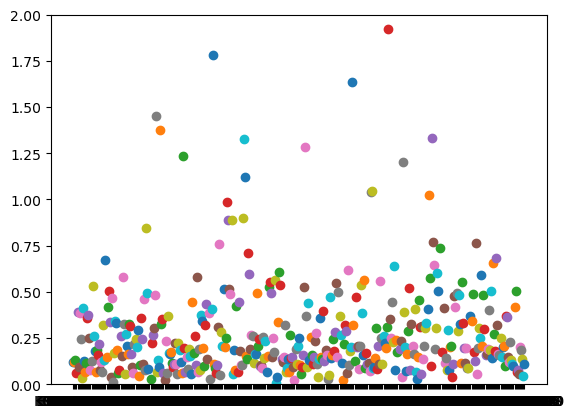

In [544]:
# MAPE for our baseline prediction
from sklearn import metrics

split_line = 0.2

num_ge = 0
num_lt = 0

def wmape(y_true, y_pred):
    #weight mean average percentage error
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

plt.ylim(top = 2)

for code in geo_data["code"]:
    test = data_test[data_test["geo_encoder__code_%s" % code] == 1]
    
    prediction = test['remainder__base'].iloc[1:]
    
    # score = metrics.r2_score(test["remainder__val"].iloc[1:], prediction)
    # score = wmape(test["remainder__val"].iloc[1:], prediction)
    score = metrics.mean_absolute_percentage_error(test["remainder__val"].iloc[1:], prediction)
    if score < split_line:
       # print("%s %f" % (code, score))
       num_lt += 1
    if score >= split_line:
        print("%s %f" % (code, score))
        num_ge +=1
    plt.scatter(code, score, marker = "o")
    
print("number of regions with score >= split: %d; <= split: %d" % (num_ge, num_lt))
plt.show()

E06000047 0.247291
E06000001 0.244429
E06000003 0.215616
E12000002 0.571893
E07000026 0.295216
E07000029 0.216401
E11000001 0.664592
E08000002 0.337900
E08000007 0.723599
E07000120 0.207688
E07000123 0.214600
E07000127 0.325632
E08000015 0.211601
E06000010 0.242228
E06000012 0.201581
E07000166 0.962006
E11000003 0.243400
E08000016 0.214924
E08000017 1.315455
E08000032 0.871663
E08000034 0.217967
E07000033 0.219194
E10000018 0.475232
E07000131 0.735136
E07000136 0.314115
E12000005 0.725800
E06000051 0.555177
E06000020 0.508857
E07000196 0.250560
E07000220 0.682153
E07000221 0.455570
E11000005 1.418087
E08000025 8.425197
E08000026 0.201237
E07000236 0.235867
E07000237 0.270024
E07000238 0.558377
E07000239 0.315990
E07000073 0.228773
E09000001 0.234493
E09000012 0.414938
E09000019 0.370707
E09000032 0.244871
E09000033 0.235881
E09000027 0.339045
E09000029 0.267779
E06000035 0.204518
E06000042 0.239694
E06000038 0.379185
E06000040 1.712789
E07000061 0.267215
E10000014 0.246573
E07000084 0.

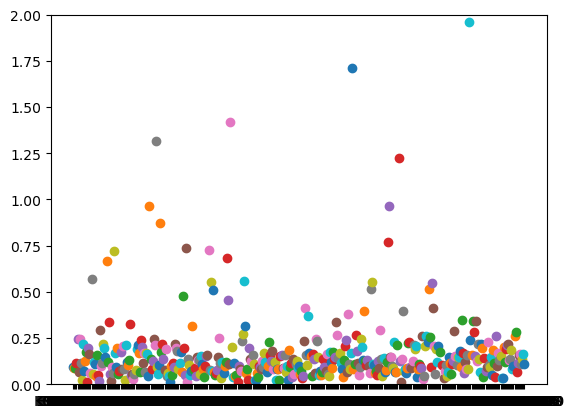

In [543]:
from sklearn import metrics

split_line = 0.2

num_ge = 0
num_lt = 0

def wmape(y_true, y_pred):
    #weight mean average percentage error
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

plt.ylim(top = 2)

for code in geo_data["code"]:
    test = data_test[data_test["geo_encoder__code_%s" % code] == 1]
    
    # Drop last value during prediction, as it has nothing we could compare with
    diff_predict = rf_mdl.predict(select_features(test.drop(test.tail(1).index)))
    
    prediction = test['remainder__base'].iloc[1:] + diff_predict
    
    # score = metrics.r2_score(test["remainder__val"].iloc[1:], prediction)
    # score = wmape(test["remainder__val"].iloc[1:], prediction)
    score = metrics.mean_absolute_percentage_error(test["remainder__val"].iloc[1:], prediction)
    if score < split_line:
       # print("%s %f" % (code, score))
       num_lt += 1
    if score >= split_line:
        print("%s %f" % (code, score))
        num_ge +=1
    plt.scatter(code, score, marker = "o")
    
print("number of regions with score >= split: %d; <= split: %d" % (num_ge, num_lt))
plt.show()

In [545]:
code = "E07000080"
# code = "K02000001"

test = data_test[data_test["geo_encoder__code_%s" % code] == 1]
    
# Drop last value during prediction, as it has nothing we could compare with
diff_predict = rf_mdl.predict(select_features(test.drop(test.tail(1).index)))
    
prediction = test['remainder__base'].iloc[1:] + diff_predict

print(metrics.mean_absolute_percentage_error(test['remainder__val'].iloc[1:], prediction))

68.33056765476907


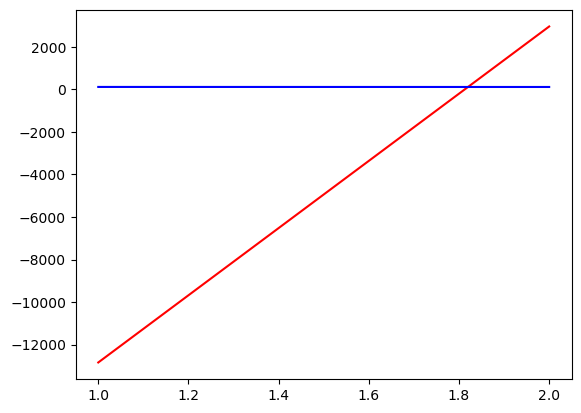

In [546]:
# The predicted next_diff should be added to the base value for the next quarter
plt.plot(np.arange(1, test.shape[0]), prediction, color = "red")
# plt.plot(np.arange(1, 4), rf_mdl.predict(select_features(test_for_specific_code)), color = "red")
plt.plot(np.arange(1, test.shape[0]), test['remainder__val'].iloc[1:], color = "blue")

plt.show()

Prediction for Code K02000001 in quarter 42: 289490.000000


/tmp/ipykernel_353799/4083622381.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  last_four_points = last_four_points.append(pd.Series([0]), ignore_index= True)
/nix/store/7vl4vagsr6b5lymv2nbaf8sz03vzn5aa-python3-3.10.8-env/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


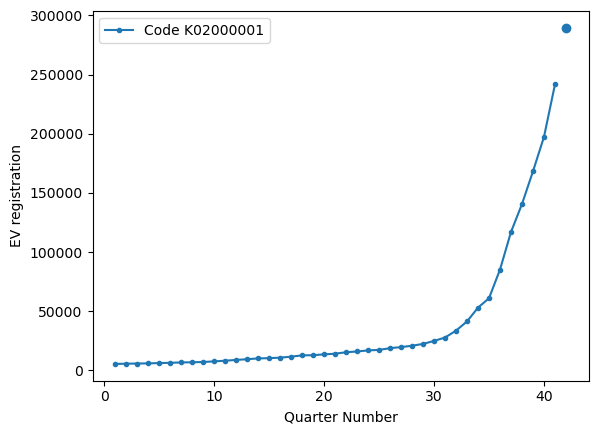

In [600]:
# Let's finally look at the prediction for next quarter (real future)
# for code in geo_data["code"].head(10):
for code in ["K02000001"]:
    last_four_points = raw_data[raw_data["code"] == code]["val"].tail(4)
    # A hacky way to make fit_poly generate the base for the next quarter
    last_four_points = last_four_points.append(pd.Series([0]), ignore_index= True)
    
    future_base = fit_poly(last_four_points)
    
    latest_point = encoded_data[encoded_data["geo_encoder__code_%s" % code] == 1].tail(1)
    # print(latest_point)
    diff_predict = rf_mdl.predict(select_features(latest_point))
    
    prediction = future_base + diff_predict[0]
    print("Prediction for Code %s in quarter 42: %f" % (code, prediction))
    
    plt.plot(np.arange(1,42,1), raw_data[raw_data["code"] == code]["val"], ".-", label="Code %s" % code)
    plt.scatter(42, prediction)

plt.xlabel("Quarter Number")
plt.ylabel("EV registration")
plt.legend()
plt.show()